# FCFS-Scheduling

> FCFS (First‐Come‐First‐Served) ist eine Scheduling‐Strategie, bei der Operationen strikt in der Reihenfolge ihres frühestmöglichen Starts – basierend auf der Ankunftszeit des Jobs und der Maschinenfreigabe – abgearbeitet werden. 


In [1]:
import sys
import os

# Projektverzeichnis
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))

# Füge dem sys.path hinzu, falls noch nicht vorhanden
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
# Datenzugriff
from configs.path_manager import get_path
import json

# Utils
import src.utils.presenter as show
from src.utils import convert
from src.utils.initialization import jobs_jssp_init as init
from src.utils.analize import check_constrains as check

# Solver Model
from src.models.heuristics import fcfs

In [3]:
# Datei laden
basic_data_path = get_path("data", "basic")
file_path = basic_data_path / "jobshop_instances.json"

with open(file_path, "r", encoding="utf-8") as f:
    jobshop_instances = json.load(f)

instance =  jobshop_instances["instance ft10"]
df_instance = convert.routing_dict_to_df(instance)
df_instance

,Routing_ID,Operation,Machine,Processing Time
0,0,0,M00,29
1,0,1,M01,78
2,0,2,M02,9
3,0,3,M03,36
4,0,4,M04,49
...,...,...,...,...
95,9,5,M09,76
96,9,6,M05,47
97,9,7,M03,52
98,9,8,M04,90


In [4]:
df_jobs = init.generate_jobs_from_routings(df_instance, shuffle = False)
df_jobs

,Job,Routing_ID,Operation,Machine,Processing Time
0,J25-0000,0,0,M00,29
1,J25-0000,0,1,M01,78
2,J25-0000,0,2,M02,9
3,J25-0000,0,3,M03,36
4,J25-0000,0,4,M04,49
...,...,...,...,...,...
95,J25-0009,9,5,M09,76
96,J25-0009,9,6,M05,47
97,J25-0009,9,7,M03,52
98,J25-0009,9,8,M04,90


**FCFS-Scheduling Algorithmus**

1. **Initialisierung**:

   * Setze Startzeit jedes Produktionsauftrags (`job_ready`) und Maschinenverfügbarkeit (`machine_ready`) auf 0.
   * Setze die nächste einzuplanende Operation jedes Jobs auf `Operation 0`.

2. **Solange noch nicht alle Operationen eingeplant sind**:

   1. Durchlaufe alle Jobs:

      * Ermittle für jede noch nicht geplante Operation die **frühestmögliche Startzeit**, basierend auf:

        * dem frühesten Abschluss der vorherigen Operation des Jobs,
        * der Verfügbarkeit der zugehörigen Maschine.
   2. Wähle unter allen betrachtbaren Jobs die **Operation mit dem kleinsten frühestmöglichen Startzeitpunkt**.

      * Bei Gleichstand: wähle den Job mit der kleineren ID.
   3. **Plane diese Operation ein**:

      * Weise ihr Start- und Endzeit zu.
      * Aktualisiere Maschinenverfügbarkeit und Jobstatus.
      * Erhöhe den Index der nächsten Operation für diesen Job.

3. **Wiederholen**, bis alle Operationen eingeplant sind.



> Dieser FCFS-Algorithmus löst Maschinenkonflikte **implizit** durch Reihenfolge im Schleifendurchlauf


In [5]:
df_schedule = fcfs.schedule(df_jobs)
df_schedule


Schedule-Informationen:
  Makespan: 1262.0


,Job,Operation,Machine,Start,Processing Time,End
0,J25-0000,0,M00,0.0,29,29.0
1,J25-0000,1,M01,91.0,78,169.0
2,J25-0000,2,M02,188.0,9,197.0
3,J25-0000,3,M03,197.0,36,233.0
4,J25-0000,4,M04,263.0,49,312.0
...,...,...,...,...,...,...
95,J25-0009,5,M09,952.0,76,1028.0
96,J25-0009,6,M05,1028.0,47,1075.0
97,J25-0009,7,M03,1075.0,52,1127.0
98,J25-0009,8,M04,1127.0,90,1217.0


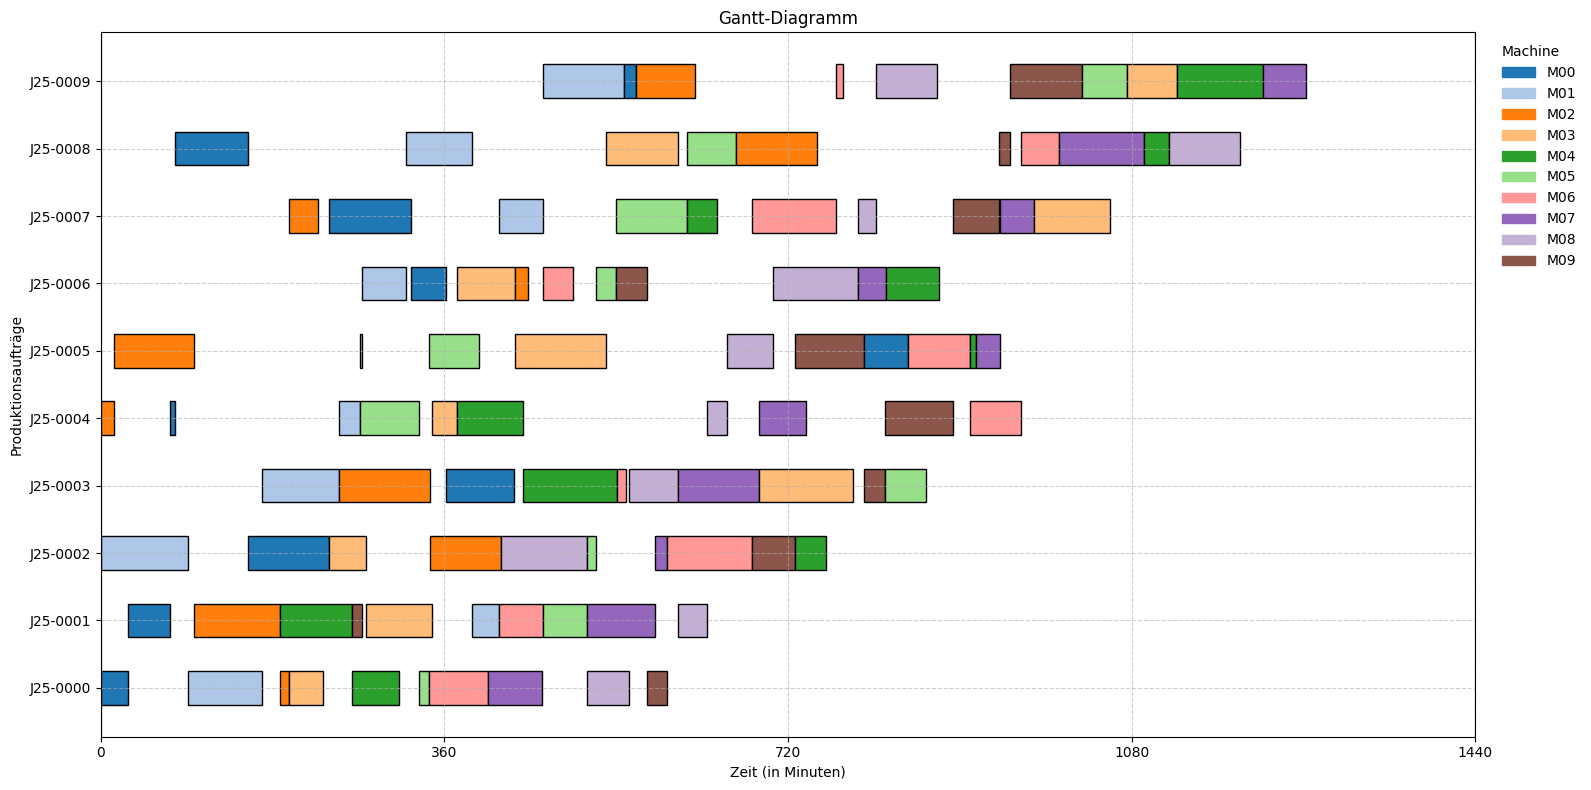

In [6]:
show.plot_gantt(df_schedule, perspective="Job")

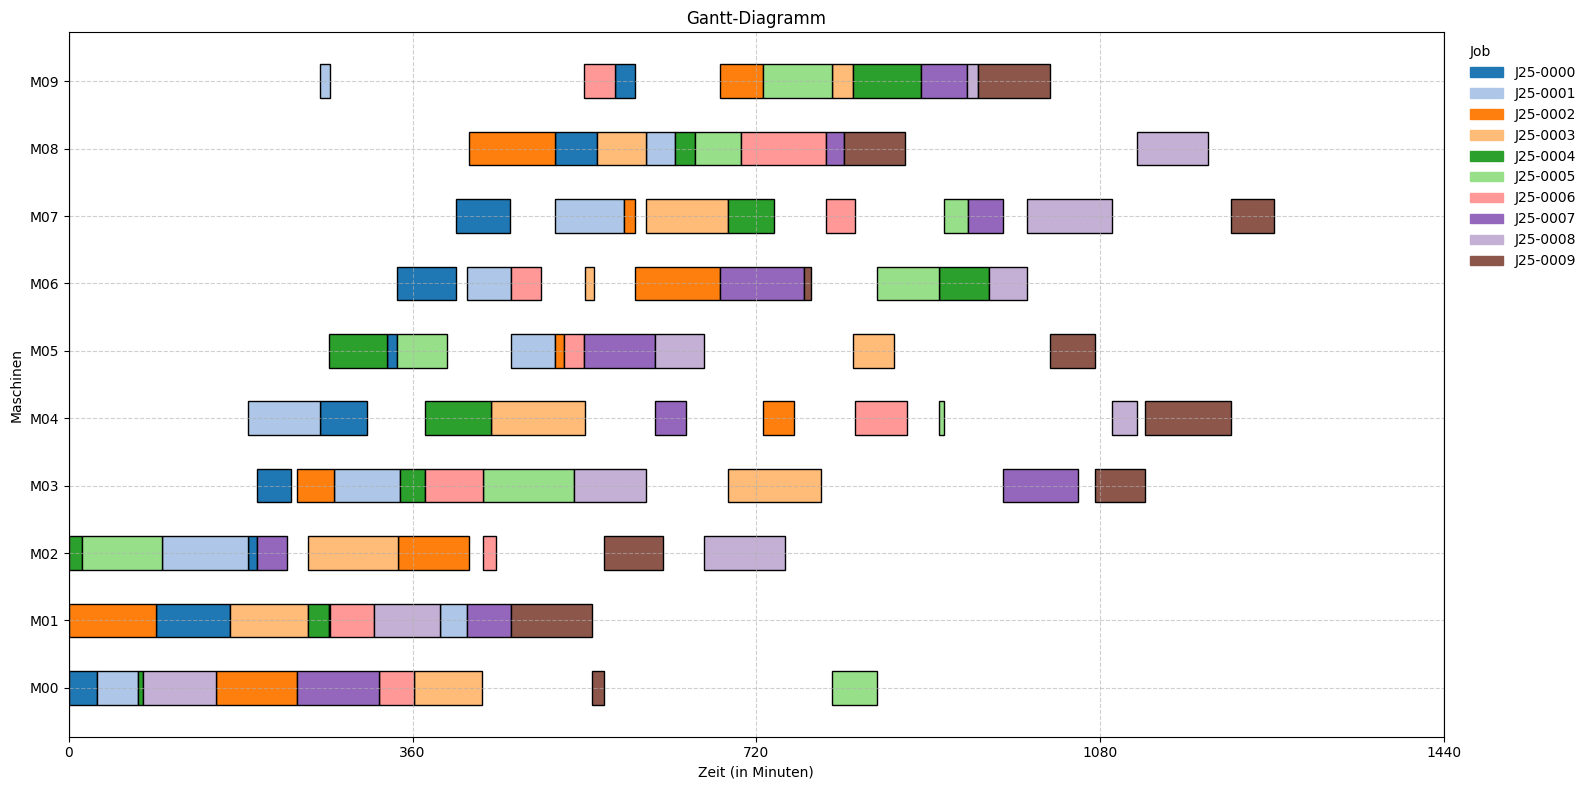

In [7]:
show.plot_gantt(df_schedule, perspective="Machine")

In [8]:
check.is_machine_conflict_free(df_schedule)
check.is_operation_sequence_correct(df_schedule)
check.is_job_timing_correct(df_schedule)

+ Keine Maschinenkonflikte gefunden
+ Alle Gruppen wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten wurden eingehalten.


True